In [3]:
import numpy as np
import cv2
from cv2 import aruco
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pprint as pp
from sklearn.preprocessing import normalize

### Load Camera parameters

In [4]:
parameter_dir=r"C:\Users\ZAIO\dev\python_aruco_marker_visualization\camera_parameters"

#load xml file
camera_parameters = {}
# camera_idxs = ["18284509","18284511","18284512"]
camera_idxs = ["18284509"]

parameter_types = ["CameraMatrix","Intrinsics","Distortion"]

for camera_idx in camera_idxs:
    fileToLoad = os.path.join(parameter_dir,camera_idx+".xml")
    fs = cv2.FileStorage(fileToLoad, cv2.FILE_STORAGE_READ)
    _camera_parameter = {}
    for parameter_type in parameter_types:
        _camera_parameter[parameter_type] = fs.getNode(parameter_type).mat()
        camera_parameters[camera_idx] = _camera_parameter

#3d points to image (2nd image)
extri = [0]*3
intri  = [0]*3
dist = [0]*3

for i in range(len(camera_idxs)):
    rotation_matrix = camera_parameters[camera_idxs[i]][parameter_types[0]][:,0:3]
    rvec,_ = cv2.Rodrigues(rotation_matrix)
    tvec = camera_parameters[camera_idxs[i]][parameter_types[0]][:,3]
    
    extri[i] = camera_parameters[camera_idxs[i]][parameter_types[0]]
    intri[i] = camera_parameters[camera_idxs[i]][parameter_types[1]]
    dist[i] = camera_parameters[camera_idxs[i]][parameter_types[2]]
   

### Select camera index

In [5]:
camera_index = 0

mtx = camera_parameters[camera_idxs[camera_index]][parameter_types[1]]
dist = camera_parameters[camera_idxs[camera_index]][parameter_types[2]]
pp.pprint(mtx)
pp.pprint(dist)
# create  Charuco board

array([[1.59106837e+03, 0.00000000e+00, 6.34909755e+02],
       [0.00000000e+00, 1.59838858e+03, 5.01707782e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
array([[ 1.36945721e-02],
       [-1.94217874e-01],
       [ 2.42371839e-04],
       [ 6.03200809e-04],
       [-4.39915075e+00],
       [ 3.17459364e-03],
       [-3.13005525e-01],
       [-3.73922900e+00]])


### Generate Charuco Board

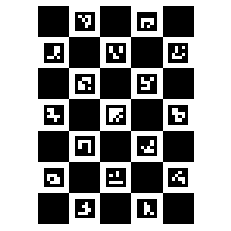

In [6]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
parameters =  aruco.DetectorParameters_create()
board = aruco.CharucoBoard_create(5, 7, 0.14, 0.088, aruco_dict)
imboard = board.draw((2000, 2000))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()

### Metric: meter

In [7]:
length_of_axis = 0.09
markerLength = 0.18

#detect Charucoboad with calibration pose

def charucoDetector(image_data,vis = False):
    frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    markerCorners, markerIds, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    imaxis = aruco.drawDetectedMarkers(frame.copy(), markerCorners, markerIds)
    retval,charucoCorners,charucoIds= cv2.aruco.interpolateCornersCharuco(markerCorners,markerIds,gray,board)
    imaxis_charuco = cv2.aruco.drawDetectedCornersCharuco(imaxis,charucoCorners,charucoIds,(0,0,255))
    
    rvecs, tvecs, _objPoints=cv2.aruco.estimatePoseSingleMarkers(markerCorners, markerLength, mtx, dist)
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, mtx, dist,rvecs,tvecs)
    imaxis_final= cv2.aruco.drawAxis(imaxis_charuco,mtx, dist, rvec,tvec,length = 0.18)
    
    print("detected marekrs: "+ str(len(rvecs)) + "/18")
    if vis == True:
        plt.figure(figsize=(15,15))
        plt.imshow(imaxis_charuco)
        plt.show()
        print("rvec")
        print(rvec)
        print("tvec")
        print(tvec)
    detected_num = len(rvecs)
    
    return rvec,tvec,detected_num

### Floor Plan reconstruced by three mareker on the floor

In [8]:
rvec_0,tvec_0, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000030_rendered.png")
rvec_X,tvec_X, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000062_rendered.png")
rvec_Y,tvec_Y, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000017_rendered.png")

detected marekrs: 16/18
detected marekrs: 11/18
detected marekrs: 11/18


In [9]:
floor_X = np.array(tvec_X-tvec_0).flatten()
floor_Y = np.array(tvec_Y-tvec_0).flatten()
floor_Z = np.cross(floor_X,floor_Y)
norm_floor_Z = floor_Z/np.linalg.norm(floor_Z)
print("[norm_floor_z]")
print(norm_floor_Z)

[norm_floor_z]
[-0.05591049 -0.94684624 -0.3167905 ]


### Floor Normal vector from rvec for each vector

In [10]:
# print(rvec_0/np.linalg.norm(rvec_0))
# print(rvec_X/np.linalg.norm(rvec_X))
# print(rvec_Y/np.linalg.norm(rvec_Y))

rtx_0, _ = cv2.Rodrigues(rvec_0)
rtx_X, _ = cv2.Rodrigues(rvec_X)
rtx_Y, _ = cv2.Rodrigues(rvec_Y)

vec_floor_x = [0,0,1]
norm_floor_rtx_0 = np.matmul(rtx_0,vec_floor_x)
norm_floor_rtx_X = np.matmul(rtx_X,vec_floor_x)
norm_floor_rtx_Y = np.matmul(rtx_Y,vec_floor_x)

# print(norm_floor_rtx_0)
# print(norm_floor_rtx_X)
# print(norm_floor_rtx_Y)
print("[norm_floor_Z from rvec]")
norm_floor_Z_rvec_average = np.average([norm_floor_rtx_0,norm_floor_rtx_X,norm_floor_rtx_Y],axis = 0)
print(norm_floor_Z_rvec_average)

[norm_floor_Z from rvec]
[-0.05774254 -0.94576818 -0.31960305]


### Differnece between signle chaurco and the multiple chaurco

In [11]:
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))
def length(v):
  return math.sqrt(dotproduct(v, v))
def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

print(np.rad2deg(angle(norm_floor_Z_rvec_average,norm_floor_Z)))
print(np.rad2deg(angle(norm_floor_rtx_0,norm_floor_Z)))
print(np.rad2deg(angle(norm_floor_rtx_X,norm_floor_Z)))
print(np.rad2deg(angle(norm_floor_rtx_Y,norm_floor_Z)))


0.20199386057806926
0.42361027112710475
0.4136978872203248
0.4333580058297975


Remove Cardboard height
 - Cardboard thickness: 17mm

In [27]:
def norm(vec):
    return vec/np.linalg.norm(vec)


### Rotation and translation matrix from 1 charuco board

In [56]:
rtx_0, _ = cv2.Rodrigues(rvec_0)
rttx = np.hstack((rtx_0,tvec_0.reshape(3,1)))
print(rttx)

[[-0.97542291  0.21140181 -0.06212422  0.4345527 ]
 [ 0.12550711  0.30132746 -0.9452247   0.71765216]
 [-0.18110248 -0.92979085 -0.32045414  5.28290166]]


### Rotation and translation matrix from 3 charuco board

In [57]:
z_vector = norm_floor_Z
dummy_vector = [1,0,0]
y_vector = np.cross(z_vector,dummy_vector)
x_vector = np.cross(y_vector,z_vector)

x_vector = norm(x_vector)
y_vector = norm(y_vector)
z_vector = norm(z_vector)

x_vector = x_vector.reshape(3,1)
y_vector = y_vector.reshape(3,1)
z_vector = z_vector.reshape(3,1)

rtx = np.hstack((x_vector,np.hstack((y_vector,z_vector))))
rttx = np.hstack((rtx, tvec_0.reshape(3,1)))
print(rttx)

[[ 0.99844806  0.         -0.05569086  0.4345527 ]
 [-0.05283449 -0.3161471  -0.94723784  0.71765216]
 [-0.01760651  0.94871018 -0.31565646  5.28290166]]


In [13]:
floor_tvec = tvec_0.flatten() - [0,0,0.017]
print(floor_tvec)

[0.4345527  0.71765216 5.26590166]


chessboard's first corner. X axis in blue color, Y axis in green color and Z axis in red color.
* corner to edge => 0.177m

In [14]:
# rvec_0,tvec_0, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000083_rendered.png",vis=True)
# rvec_X,tvec_X, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000102_rendered.png",vis=True)
# rvec_Y,tvec_Y, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000120_rendered.png",vis=True)

In [15]:
rtx_0 = cv2.Rodrigues(rvec_0)[0]
print(rtx_0)
tvec_3_1 = tvec_0.reshape(3,1)
print(np.hstack((rtx_0,tvec_3_1)))

[[-0.97542291  0.21140181 -0.06212422]
 [ 0.12550711  0.30132746 -0.9452247 ]
 [-0.18110248 -0.92979085 -0.32045414]]
[[-0.97542291  0.21140181 -0.06212422  0.4345527 ]
 [ 0.12550711  0.30132746 -0.9452247   0.71765216]
 [-0.18110248 -0.92979085 -0.32045414  5.28290166]]


In [16]:
def rtvec2rtx (rvec,tvec):
    rtx = cv2.Rodrigues(rvec)[0]
    return np.hstack((rtx,tvec.reshape(3,1)))

In [17]:
rtx_0 = rtvec2rtx(rvec_0,tvec_0)
rtx_X = rtvec2rtx(rvec_X,tvec_X)
rtx_Y = rtvec2rtx(rvec_Y,tvec_Y)

In [18]:
coner2edge = [0,-0.177,0,1]

tvec_0_floor = np.matmul(rtx_0,coner2edge)
tvec_X_floor = np.matmul(rtx_X,coner2edge)
tvec_Y_floor = np.matmul(rtx_Y,coner2edge)

floor_X = np.array(tvec_X_floor-tvec_0_floor).flatten()
floor_Y = np.array(tvec_Y_floor-tvec_0_floor).flatten()
floor_Z = np.cross(floor_X,floor_Y)
norm_floor_Z = floor_Z/np.linalg.norm(floor_Z)
print("[norm_floor_z]")
print(norm_floor_Z)



[norm_floor_z]
[-0.05569086 -0.94723784 -0.31565646]


In [19]:
a = np.array([1,0,0])
b = np.array([0,1,0])
print(np.cross(a,b))

[0 0 1]
